<a href="https://colab.research.google.com/github/Artmalik92/Congruence-Test-For-Students/blob/main/geometry_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В системах геодезического мониторинга одним из методов обнаружения деформаций является построение ГНСС сетей и анализ движений в них при помощи вычисления невязок в замкнутых фигурах или геометрической модели. Геометрическая модель использует геометрические свойства объектов. Например, можно использовать геометрические связи между точками (углы и расстояния) для определения их относительного положения и оценки стабильности измерений. Данный принцип можно реализовать в виде программы геометрического теста на Python.

Геометрический тест стабильности позволяет выявлять аномальные движения в замкнутой геодезической сети путем вычисления разностей параметров этой сети (внутренних углов, длин базовых линий или координат) на начальную и i-ую эпоху. После этого производится статистическая оценка разностей. Если сумма разностей между параметрами статистически не значима, то эти две фигуры конгруэнтны, т. е. аномальных движений нет.

Библиотеки, которые нам понадобятся:

In [26]:
import pandas
import numpy
from scipy.stats import chi2
from scipy.linalg import block_diag

Библиотека **pandas** необходима для обработки и структурирования данных в виде таблиц.
**Numpy** используется для выполнения математических операций с матрицами и другими массивами. **Scipy** содержит модуль **stats**, который позволяет выполнять в Python статистические операции, в частности тест Хи-квадрат, который мы будем использовать. Модуль linalg позволяет составлять блочные диагональные матрицы, он понадобится нам при выполнении линейной регрессии.

Для начала подготовим тестовый временной ряд координат, на котором будем испытывать код программы. Для этого напишем функцию:

In [55]:
def generate_coordinates(noise, observations, start_coordinate, offset=None):

    # сгенерируем координаты без смещений
    segment = numpy.full(observations*7, start_coordinate)

    # объединяем сегменты в один массив
    Coordinates = numpy.hstack([segment]).astype(float)

    if offset:
        # сгенерируем несколько сегментов временного ряда координаты U со смещением
        segment_1 = numpy.full(observations, start_coordinate + offset)
        segment_2 = numpy.full(observations, start_coordinate + offset*2)
        segment_3 = numpy.full(observations, start_coordinate + offset*3)
        segment_4 = numpy.full(observations, start_coordinate + offset*4)
        segment_5 = numpy.full(observations, start_coordinate + offset*5)
        segment_6 = numpy.full(observations, start_coordinate + offset*6)
        segment_7 = numpy.full(observations, start_coordinate + offset*7)

        # объединяем сегменты в один массив
        Coordinate_U = numpy.hstack([segment_1, segment_2, segment_3,
                                segment_4, segment_5, segment_6,
                                segment_7]).astype(float)

    else:
        # сгенерируем координаты U без смещений
        Coordinate_U = numpy.hstack([segment]).astype(float)

    # добавляем шум в измерения в виде случайного числа с разбросом 0.005
    Coordinates += numpy.random.normal(0, noise, observations*7)
    Coordinate_U += numpy.random.normal(0, noise, observations*7)

    # Добавляем столбцы с СКП
    sigmas = numpy.hstack([numpy.ones(observations*7)*noise])

    # преобразуем в таблицу DataFrame для дальнейшего использования
    df = pandas.DataFrame({0: Coordinates,
                        1: Coordinates + 0.1,
                        2: Coordinate_U + 0.2,
                        3: sigmas, 4: sigmas, 5: sigmas})
    return df

При помощи данной функции сгенерируем 4 временных ряда, чтобы смоделировать геодезическую сеть из 4-х станций.
Первые 3 столбца таблицы содержат координаты E, N, U, следующие 3 столбца - их СКП.

In [ ]:
''' Исходные данные '''
noise = 0.005           # Амплитуда шума в измерениях
offset = 0.05           # Амплитуда смещения координаты
observations = 50       # количество измерений

# Сгенерируем 4 временных ряда, для каждой станции
df1 = generate_coordinates(noise=noise, observations=observations,
                           start_coordinate=100, offset=offset)
df2 = generate_coordinates(noise=noise, observations=observations,
                           start_coordinate=50)
df3 = generate_coordinates(noise=noise, observations=observations,
                           start_coordinate=70)
df4 = generate_coordinates(noise=noise, observations=observations,
                           start_coordinate=95)

Так будет выглядеть станция, испытывающая вертикальные деформации:

              0           1           2      3      4      5
0    100.003245  100.103245  100.260230  0.005  0.005  0.005
1     99.994297  100.094297  100.252872  0.005  0.005  0.005
2     99.996885  100.096885  100.250416  0.005  0.005  0.005
3     99.996702  100.096702  100.255089  0.005  0.005  0.005
4     99.988615  100.088615  100.248426  0.005  0.005  0.005
..          ...         ...         ...    ...    ...    ...
345   99.994565  100.094565  100.545182  0.005  0.005  0.005
346   99.999867  100.099867  100.552632  0.005  0.005  0.005
347  100.003065  100.103065  100.548966  0.005  0.005  0.005
348  100.006902  100.106902  100.544279  0.005  0.005  0.005
349  100.003556  100.103556  100.553098  0.005  0.005  0.005

[350 rows x 6 columns]


<Axes: >

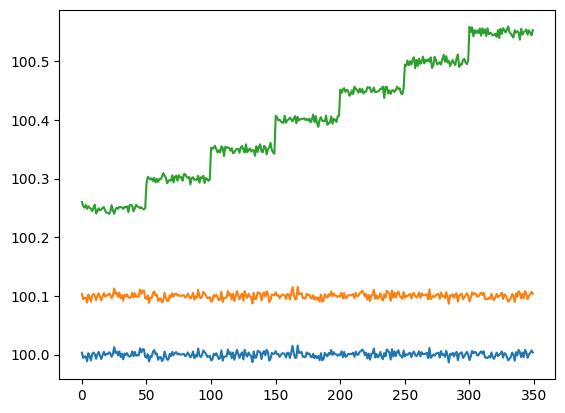

In [81]:
print(df1)
df1[0].plot()
df1[1].plot()
df1[2].plot()

Остальные станции будут неподвижными:

<Axes: >

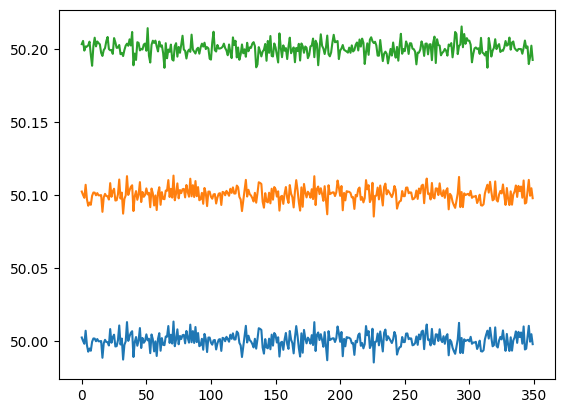

In [57]:
df2[0].plot()
df2[1].plot()
df2[2].plot()

Затруднительно напрямую использовать координаты станций, полученные из файлов обработки ГНСС наблюдений. Станции могут записывать измерения с разной частотой, а также в файлах результатах обработки могут отличаться эпохи наблюдений. Поэтому координаты требуется привести к некоторой общей эпохе. Это можно выполнить при помощи линейной регрессии. Она также позволяет уменьшить влияние шума в измерениях. Для этого напишем функцию:

In [58]:
def linear_regression(time_series_frag, sigma_0) :
    """
    Данная функция выполняет линейную регрессию для данного фрагмента временного ряда

    Аргументы:
        time_series_frag (DataFrame): Фрагмент временного ряда
        sigma_0 (float): Значение СКП

    Возвращает:
        tuple: Кортеж с координатами, вычисленными с помощью линейной регрессии
    """
    # переделка массива с координатами в общий вектор свободных членов
    L = numpy.zeros((time_series_frag.shape[0]*3))
    Q = numpy.zeros((time_series_frag.shape[0]*3,time_series_frag.shape[0]*3))
    for i in range (time_series_frag.shape[0]) :
        L[3*i] = time_series_frag.iloc[i][0]
        L[3*i+1] = time_series_frag.iloc[i][1]
        L[3*i+2] = time_series_frag.iloc[i][2]
        Q[3*i,3*i] = time_series_frag.iloc[i][3]**2
        Q[3*i+1,3*i+1] = time_series_frag.iloc[i][4]**2
        Q[3*i+2,3*i+2] = time_series_frag.iloc[i][5]**2

    # задаем массив эпох
    t = numpy.arange(0, time_series_frag.shape[0], 1)

    # цикл формирования матрицы коэффициентов
    for m in range (time_series_frag.shape[0]):
        ti = t[m]
        if m == 0 : A=numpy.hstack((numpy.identity(3)*ti, numpy.identity(3)))
        else:
            Aux=numpy.hstack((numpy.identity(3)*ti, numpy.identity(3)))
            A=numpy.vstack((A, Aux))

    #формирование матрицы весов
    P = Q / sigma_0 ** 2

    # решаем СЛАУ
    N = A.transpose().dot(numpy.linalg.inv(P)).dot(A)
    # вектор параметров кинематической модели
    X = numpy.linalg.inv(N).dot(A.transpose().dot(numpy.linalg.inv(P)).dot(L))
    x_LS = numpy.array([X[0]*t[-1]+X[3], X[1]*t[-1]+X[4], X[2]*t[-1]+X[5]])

    #вычисляем вектор невязок
    V = A.dot(X) - L

    # СКП единицы веса
    mu = numpy.sqrt((V.transpose().dot(numpy.linalg.inv(P)).dot(V))/(V.shape[0]-6))

    Qx = numpy.linalg.inv(N)
    С = numpy.array([[t[-1],0,0,1,0,0],[0,t[-1],0,0,1,0],[0,0,t[-1],0,0,1]])

    Qv = С.dot(Qx).dot(С.transpose())

    return (x_LS,Qv,mu, Qx,V)

Для выполнения линейной регрессии необходимо разделить временной ряд на равные отрезки, так называемые "окна". На конец каждого окна в результате линейной регрессии будут получены усредненные координаты. Далее можно попробовать определить моменты деформаций. Для этого мы вычисляем вектор скорости каждой станции на каждую эпоху (в коде обозначен как d). После чего мы используем тест Хи-квадрат для определения, насколько ожидаемые значения (test_value) этого вектора совпадают с наблюдаемыми (test_statistic). Для этого напишем функцию:

In [75]:
def geometric_test_statictics(time_serieses_df, window, sigma_0):
    """
    Функция разделяет временной ряд на окна, затем выполняет линейную регрессию
    и рассчет статистики геометрического теста.

    Аргументы:
        time_series_df (DataFrame): Временной ряд координат
        window (int): Размер окна (в данном случае кол-во эпох)
        sigma_0 (float): Значение СКП

    Возвращает:
        tuple: Кортеж с координатами, вычисленными с помощью линейной регрессии,
               а также результаты геометрического теста
    """
    # Создаем необходимые списки для хранения данных
    time_series_df = time_serieses_df[0]
    epochs = int(time_series_df.shape[0]/window)
    X_WLS = numpy.ndarray(shape=(epochs,1,12))
    Qv_WLS = numpy.ndarray(shape=(epochs,3*4,3*4))
    mu_WLS = numpy.zeros(epochs)
    time_series_df = time_serieses_df[0]

    # Цикл для разделения временного ряда на окна
    end = 0
    for j in range (epochs) :
        st = end
        end = int((j + 1) * window)

        x_LS1, Qv1, mu1, Qx, V = linear_regression(df1.iloc[st:end],0.005)
        x_LS2, Qv2, mu2, Qx, V = linear_regression(df2.iloc[st:end],0.005)
        x_LS3, Qv3, mu3, Qx, V = linear_regression(df3.iloc[st:end],0.005)
        x_LS4, Qv4, mu4, Qx, V = linear_regression(df4.iloc[st:end],0.005)

        mu_WLS[j] = mu1**2 + mu2**2 + mu3**2 + mu4**2
        X_WLS[j] = numpy.hstack((x_LS1,x_LS2,x_LS3,x_LS4))
        Qv_WLS[j] = block_diag(Qv1,Qv2,Qv3,Qv4)

    # список для хранения значений статистики
    test_statistic = numpy.zeros((epochs-1))

    # список для хранения эпох с отвергнутой гипотезой
    rejected_epochs = []

    # Расчет статистики при помощи теста Хи-квадрат
    for l in range(epochs-1):
        Qdd = Qv_WLS[l] + Qv_WLS[l+1]
        d = X_WLS[l]-X_WLS[l+1]
        sigma_0 = mu_WLS[l] + mu_WLS[l+1]
        test_statistic[l] = d.dot(numpy.linalg.inv(Qdd)).dot(d.transpose())/sigma_0
        test_value = chi2.ppf(df=((d.shape[0])/3)*6, q=0.95)
        if test_statistic[l] > test_value :
            print('reject, l =',l*window)
            print('test_value =',test_value)
            print('test_statistic =',test_statistic[l])
            rejected_epochs.append(l*window)

    return X_WLS, Qv_WLS, test_statistic, rejected_epochs

Далее выполним геометрический тест на сгенерированной сети пунктов:

In [76]:
X_WLS, Qv_WLS, test_statistic, rejected_epochs = geometric_test_statictics(time_serieses_df=df1, window=5, sigma_0=0.05)

reject, l= 45
test_value = 5.991464547107979
test_statistic = 9.455269943924725
reject, l= 95
test_value = 5.991464547107979
test_statistic = 9.581236504519877
reject, l= 145
test_value = 5.991464547107979
test_statistic = 11.795155885695475
reject, l= 195
test_value = 5.991464547107979
test_statistic = 12.99104503444294
reject, l= 245
test_value = 5.991464547107979
test_statistic = 6.9878231866921405
reject, l= 295
test_value = 5.991464547107979
test_statistic = 17.150201352934403


<ipython-input-75-3e7bf6d5ae27>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_statistic[l]=d.dot(numpy.linalg.inv(Qdd)).dot(d.transpose())/sigma_0


Визуализируем результаты на графике при помощи библиотеки **matplotlib**.

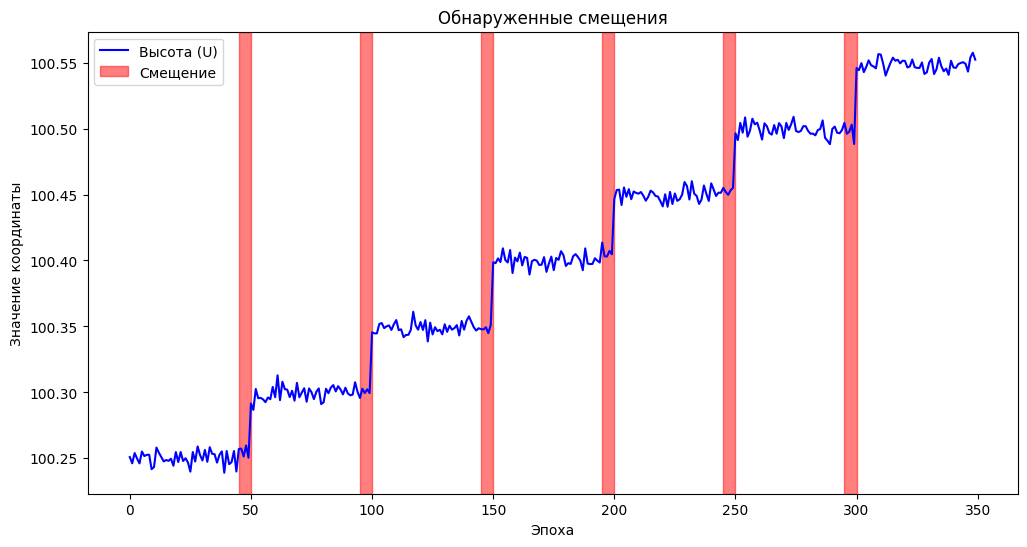

In [79]:
import matplotlib.pyplot as plt

# создаем график
plt.figure(figsize=(12, 6))

# отображаем колонку со значениями высоты
plt.plot(df1[2], label='Высота (U)', color='blue')

# подсвечиваем эпохи, которые содержат деформации
for epoch in rejected_epochs:
    plt.axvspan(epoch, epoch + 5, color='red', alpha=0.5, label=f'Смещение' if epoch == rejected_epochs[0] else "")

plt.title('Обнаруженные смещения')
plt.xlabel('Эпоха')
plt.ylabel('Значение координаты')
plt.legend()

# Показать график
plt.show()